# Customer Churn
A comparison of logistic regression, random forests, and deep learning models.

## The Data
https://www.kaggle.com/blastchar/telco-customer-churn

Each row represents a customer, each column contains customer’s attributes described on the column Metadata. The raw data contains 7043 rows (customers) and 21 columns (features). The “Churn” column is our target.

In [1]:
# import libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline

In [2]:
# Load and read data
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv') 
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# See the data-types and count
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [4]:
# Summarize dataset 
print('Rows     : ', data.shape[0])
print('Columns  : ' ,data.shape[1])
print('\n{} Numerical Features: {}'.format(len(data._get_numeric_data().columns), 
                                         data._get_numeric_data().columns.tolist()))
print ('\n{} Categorical Features: {}'.format(len(data.select_dtypes(exclude=['int', 'float']).columns),
                                                                      data.select_dtypes(exclude=['int', 'float']).columns.tolist()))

Rows     :  7043
Columns  :  21

3 Numerical Features: ['SeniorCitizen', 'tenure', 'MonthlyCharges']

18 Categorical Features: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']


In [5]:
# Look at unique values, labels vs continuous
# ukeys = 5
# print ('\n{} Unique values < 5 : {}'.format(len(data.nunique()[data.nunique() < ukeys ].keys()), 
#                                             data.nunique()[data.nunique() < ukeys].keys().tolist()))
print('\nUnique values per column:')
print(data.nunique())


Unique values per column:
customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


In [6]:
# Examine target
data['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

## Check Null / Constant / Duplicate Values
We want to delete columns and rows that have no values. Features with one constant value or features with duplicate values need to be deleted.

In [7]:
# Check rows with spaces
data = data.replace(' ', np.nan)
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [8]:
# Find columns where all values are null
print('Columns where all values are null:', len(data.columns[data.isnull().all()]))
print('Columns with values:', len(data.columns) - len(data.columns[data.isnull().all()]))
print('Columns with no null values:', len(data.columns[data.notnull().all()]))

Columns where all values are null: 0
Columns with values: 21
Columns with no null values: 20


In [9]:
# Show null rows
all_null_rows = data[data.drop(['customerID'], axis=1).isnull().all(1)].index.values
print('Row index where all values are null:', all_null_rows)

Row index where all values are null: []


In [10]:
# Show row index with null values
with_null = data[data.drop(['customerID'], axis=1).isnull().any(1)].index.values
print(with_null)

[ 488  753  936 1082 1340 3331 3826 4380 5218 6670 6754]


In [11]:
# Since only 11 rows let's delete them
print('Original shape: ', data.shape)
data.drop(data.index[with_null], inplace=True)
print('Shape after deletion: ', data.shape)

Original shape:  (7043, 21)
Shape after deletion:  (7032, 21)


In [12]:
# Check for features that have i value
for i in range(5):
    constant_features = [
        feat for feat in data.columns if len(data[feat].unique()) == i
    ]

    print('Features with {} unique values: {}'.format(i, len(constant_features)))


Features with 0 unique values: 0
Features with 1 unique values: 0
Features with 2 unique values: 7
Features with 3 unique values: 9
Features with 4 unique values: 1


In [13]:
# Check  for Quasi Constant Values, does not count null values
for col in data.columns.sort_values():
    if (len(data[col].unique()) < 5):
        print(data[col].value_counts())
        print()

No     5163
Yes    1869
Name: Churn, dtype: int64

Month-to-month    3875
Two year          1685
One year          1472
Name: Contract, dtype: int64

No     4933
Yes    2099
Name: Dependents, dtype: int64

No                     3094
Yes                    2418
No internet service    1520
Name: DeviceProtection, dtype: int64

Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64

No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64

No                     3087
Yes                    2425
No internet service    1520
Name: OnlineBackup, dtype: int64

No                     3497
Yes                    2015
No internet service    1520
Name: OnlineSecurity, dtype: int64

Yes    4168
No     2864
Name: PaperlessBilling, dtype: int64

No     3639
Yes    3393
Name: Partner, dtype: int64

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit car

In [14]:
# Check for columns with duplicate values
duplicated_feat = []
for i in range(0, len(data.columns)):
    if i % 10 == 0:  # Keep track of the loop
        print('loop tracker', i)

    col_1 = data.columns[i]

    for col_2 in data.columns[i + 1:]:
        if data[col_1].equals(data[col_2]):
            duplicated_feat.append(col_2)
            
# Number of duplicated features
print('Number of duplicated features', len(set(duplicated_feat)))

loop tracker 0
loop tracker 10
loop tracker 20
Number of duplicated features 0


In [15]:
# Drop customerID
data.drop(['customerID'], axis=1, inplace=True)

## Check Outliers

In [16]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208
std,0.368844,24.545260,30.085974
min,0.000000,1.000000,18.250000
25%,0.000000,9.000000,35.587500
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.862500
max,1.000000,72.000000,118.750000


In [17]:
#Check for outliers
outliers = pd.DataFrame()
for feat in data._get_numeric_data().columns:
#     q1, q3= np.percentile(outliers[feat],[25,75])
#     iqr = q3 - q1
#     Lower_fence = q1 -(1.5 * iqr) 
#     Upper_fence = q3 +(1.5 * iqr) 

    IQR = data[feat].quantile(0.75) - data[feat].quantile(0.25)
    Lower_fence = data[feat].quantile(0.25) - (IQR * 1.5)
    Upper_fence = data[feat].quantile(0.75) + (IQR * 1.5)

    outliers[feat] = data[feat].apply(lambda x: x if x >= Lower_fence and x <= Upper_fence else np.nan)

print(outliers.shape)
for feat in outliers.columns:
    print('{: >30}: {}'.format(feat, outliers[feat].isnull().sum()-data[feat].isnull().sum()))

(7032, 3)
                 SeniorCitizen: 1142
                        tenure: 0
                MonthlyCharges: 0


## Convert Object Data to Numeric

In [18]:
# Convert TotalCharges str to numeric
data.TotalCharges = pd.to_numeric(data.TotalCharges)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
tenure              7032 non-null int64
PhoneService        7032 non-null object
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
Contract            7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
Churn               7032 non-null object
dtypes: float64(2), int64(2), object(16)
memory usage: 1.1+ MB


## Normalize Data

In [19]:
# Scale features
from sklearn.preprocessing import StandardScaler

cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

sc = StandardScaler()
data[cols_to_scale] = sc.fit_transform(data[cols_to_scale])
# scaled = sc.fit_transform(data[cols_to_scale])
# scaled = pd.DataFrame(scaled, columns=cols_to_scale)
# print(scaled.shape)
# df_scaled = data.drop(columns = cols_to_scale, axis = 1)
# df_scaled = scaled.merge(df_scaled, left_on=right_index=True, how = "left")

data.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [20]:
# Dbl check categorical data for one hot encoding
print('Unique values per categorical feature:')
print(data.select_dtypes(include=['object']).nunique())
print(data.shape)

Unique values per categorical feature:
gender              2
Partner             2
Dependents          2
PhoneService        2
MultipleLines       3
InternetService     3
OnlineSecurity      3
OnlineBackup        3
DeviceProtection    3
TechSupport         3
StreamingTV         3
StreamingMovies     3
Contract            3
PaperlessBilling    2
PaymentMethod       4
Churn               2
dtype: int64
(7032, 20)


## One Hot Encoding

In [21]:
# One hot categorical data
df = pd.get_dummies(data, 
                    columns=data.drop(['Churn'], axis=1).select_dtypes(include=['object']).columns.values, 
                    drop_first=True)

# Fix column names
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.rename(columns={'paymentmethod_credit_card_(automatic)':'paymentmethod_credit_card_automatic'}, inplace=True)

# Make Churn 1 and 0
churn_map = {
    'No': 0,
    'Yes': 1
}

df.churn = df.churn.map(churn_map)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 31 columns):
seniorcitizen                           7032 non-null int64
tenure                                  7032 non-null float64
monthlycharges                          7032 non-null float64
totalcharges                            7032 non-null float64
churn                                   7032 non-null int64
gender_male                             7032 non-null uint8
partner_yes                             7032 non-null uint8
dependents_yes                          7032 non-null uint8
phoneservice_yes                        7032 non-null uint8
multiplelines_no_phone_service          7032 non-null uint8
multiplelines_yes                       7032 non-null uint8
internetservice_fiber_optic             7032 non-null uint8
internetservice_no                      7032 non-null uint8
onlinesecurity_no_internet_service      7032 non-null uint8
onlinesecurity_yes                      7032 no

In [22]:
# Check duplicate values again after one hot encoding
duplicated_feat = []
for i in range(0, len(df.columns)):
    if i % 10 == 0:  # Keep track of the loop
        print('loop tracker', i)

    col_1 = df.columns[i]

    for col_2 in df.columns[i + 1:]:
        if df[col_1].equals(df[col_2]):
            duplicated_feat.append(col_2)
            
# Number of duplicated features
print('Number of duplicated features', len(set(duplicated_feat)))
print('Duplicated features: ', set(duplicated_feat))

loop tracker 0
loop tracker 10
loop tracker 20
loop tracker 30
Number of duplicated features 6
Duplicated features:  {'onlinebackup_no_internet_service', 'onlinesecurity_no_internet_service', 'streamingtv_no_internet_service', 'streamingmovies_no_internet_service', 'techsupport_no_internet_service', 'deviceprotection_no_internet_service'}


In [23]:
# Delete duplicate features
print(df.shape)
df.drop(labels=duplicated_feat, axis=1, inplace=True)
print(df.shape)

(7032, 31)
(7032, 25)


## Split Data Into Train Test Sets
It is good practice to do feature selection on training data to address overfitting and leakage. Data leakage is when information from outside the training dataset is used to create the model.

In [24]:
# Separate dataset into train, validate, and test
from sklearn.model_selection import train_test_split

features = df.drop(['churn'], axis=1)
target = df.churn

X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.3,
    random_state=1)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4922, 24)
X_test shape:  (2110, 24)
y_train shape:  (4922,)
y_test shape:  (2110,)


## Feature Awareness
Explore features for correlation, collinearity, feature importance

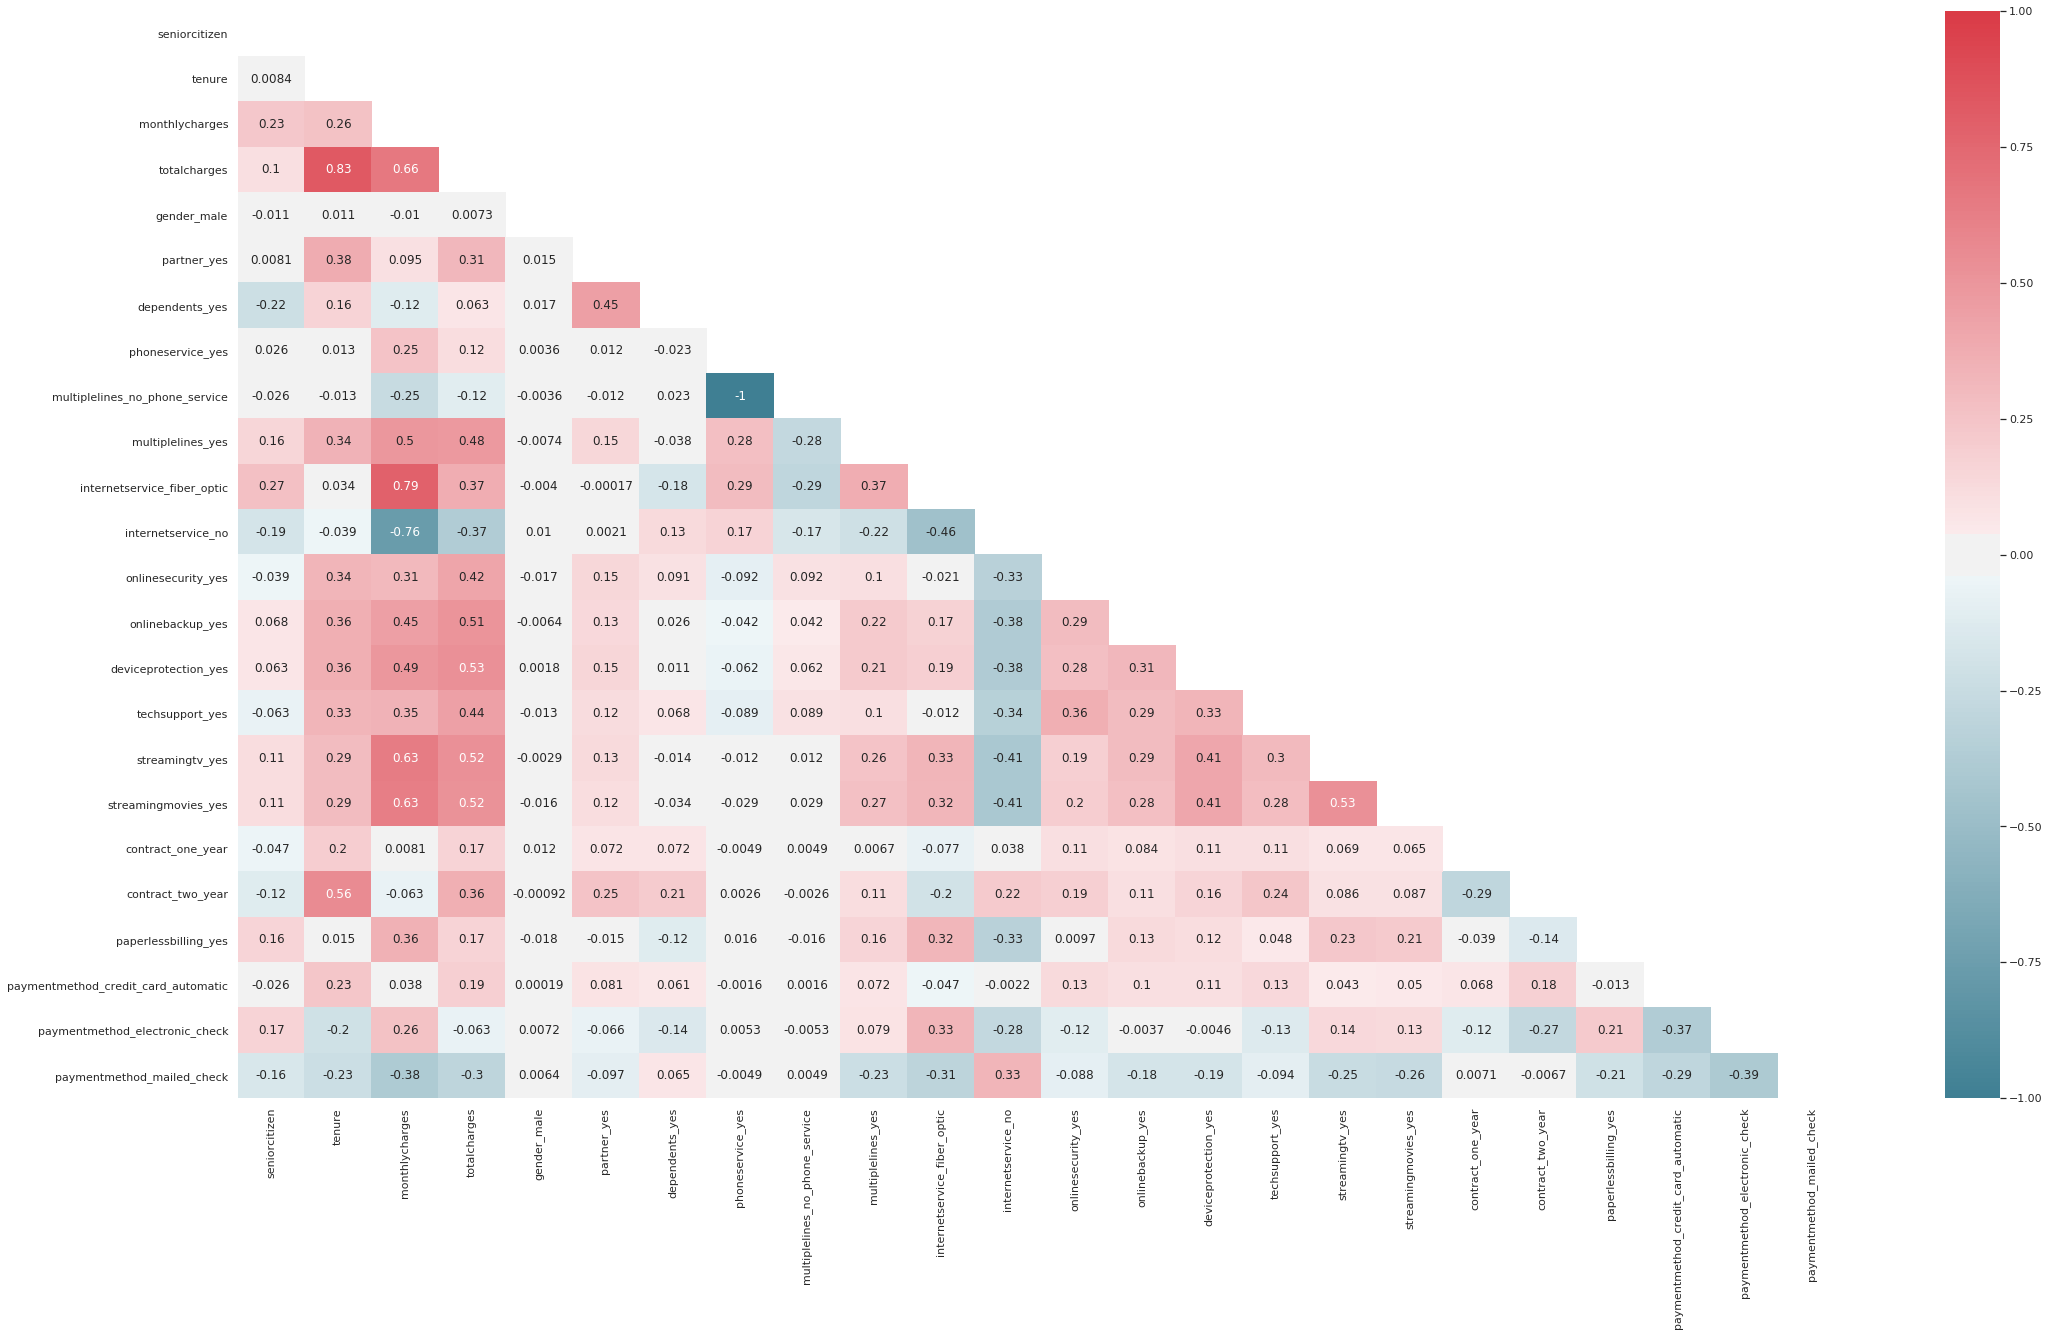

In [25]:
# Correlation Matrix
sns.set(style="white")

# Compute the correlation matrix
corr = X_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(36,20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True)

In [26]:
# Create function to identify highly correlated features
corrmat = X_train.corr()
corrmat = corrmat.abs().unstack()
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat <= 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

,feature1,feature2,corr
0,paymentmethod_mailed_check,paymentmethod_mailed_check,1.0
1,internetservice_fiber_optic,internetservice_fiber_optic,1.0
2,paperlessbilling_yes,paperlessbilling_yes,1.0
3,contract_two_year,contract_two_year,1.0
4,contract_one_year,contract_one_year,1.0


In [27]:
# Find groups of correlated features

grouped_feature_ls = []
correlated_groups = []
correlated_list = set()

for feature in corrmat.feature1.unique():
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(correlated_block.feature2.unique()) + [feature]
        
        # append the block of features to the list
        if len(correlated_block) > 1:
            correlated_groups.append(correlated_block)
            for block in correlated_block.feature1.append(correlated_block.feature2):
                correlated_list.add(block)

print(correlated_list)
print('Found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(features.shape[1]))

{'phoneservice_yes', 'tenure', 'totalcharges', 'multiplelines_no_phone_service'}
Found 2 correlated groups
out of 24 total features


In [28]:
# Examine the groups
for group in correlated_groups:
    print(group)
    print()

                          feature1                        feature2  corr
14  multiplelines_no_phone_service  multiplelines_no_phone_service   1.0
15  multiplelines_no_phone_service                phoneservice_yes   1.0

        feature1      feature2      corr
21  totalcharges  totalcharges  1.000000
27  totalcharges        tenure  0.828701



In [29]:
# Use RandomForest for reature importance
from sklearn.ensemble import RandomForestClassifier

# features = list(group.feature1.unique())
rf_features = list(correlated_list)
rf = RandomForestClassifier(n_estimators=200, max_depth=4)
rf.fit(X_train[rf_features], y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [30]:
# This is our first test for feature selection. 
# Initiate possible_drop_features to store groups of possible feature to drop
# Random Forest feature importance
possible_drop_features = {}

importance = pd.concat(
    [pd.Series(rf_features),
     pd.Series(rf.feature_importances_)], axis=1)

importance.columns = ['feature', 'importance']
rf_importance = importance.sort_values(by='importance', ascending=False).feature.values
possible_drop_features['rf_non_importance'] = list(rf_importance)
print(importance.sort_values(by='importance', ascending=False))
# print(possible_drop_features)

                          feature  importance
1                          tenure    0.617383
2                    totalcharges    0.363873
3  multiplelines_no_phone_service    0.010880
0                phoneservice_yes    0.007863


## Collinearity

In [31]:
df_collinearity = pd.DataFrame(X_train.copy(), columns=features.columns)
df_collinearity['target'] = target
df_collinearity.head()

,seniorcitizen,tenure,monthlycharges,totalcharges,gender_male,partner_yes,dependents_yes,phoneservice_yes,multiplelines_no_phone_service,multiplelines_yes,...,techsupport_yes,streamingtv_yes,streamingmovies_yes,contract_one_year,contract_two_year,paperlessbilling_yes,paymentmethod_credit_card_automatic,paymentmethod_electronic_check,paymentmethod_mailed_check,target
1584,1,1.327365,-0.375557,0.544690,0,0,0,0,1,0,...,0,1,1,0,1,1,0,0,0,0
1043,0,-0.017185,0.164600,0.028501,1,1,1,1,0,0,...,0,0,0,0,0,1,0,0,0,1
1077,0,0.349510,1.652110,0.990091,0,0,0,1,0,1,...,1,1,1,0,0,1,0,0,0,1
2478,0,-1.158016,-0.673059,-0.909971,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
6908,0,-0.954296,-0.314063,-0.808939,1,0,1,1,0,0,...,0,1,0,0,0,0,0,1,0,1


In [32]:
# VIF
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

coll_feats = '+'.join(df_collinearity.drop(['target'], axis=1).columns)
y, X = dmatrices('target ~' + coll_feats, df_collinearity, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(2).sort_values(by='VIF Factor', ascending=False)

/home/cliffo/anaconda3/envs/tf2/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/cliffo/anaconda3/envs/tf2/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
8,inf,phoneservice_yes
9,inf,multiplelines_no_phone_service
3,865.58,monthlycharges
11,147.79,internetservice_fiber_optic
12,102.51,internetservice_no
18,24.02,streamingmovies_yes
17,23.92,streamingtv_yes
4,10.90,totalcharges
2,7.55,tenure
10,7.25,multiplelines_yes


In [33]:
high_vif = vif['VIF Factor'] > 7
possible_drop_features['high_vif'] = list(vif[high_vif].features.values)
# print(possible_drop_features)
# X_train.drop(['target'], axis=1, inplace=True)

In [34]:
# Calculate the mutual information between the variables and the target.
# The smaller the value the less information the feature has about the target
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi)
mi.index = features.columns.values
mutual_info = mi.sort_values(ascending=False)
print(mi.sort_values(ascending=False))
possible_drop_features['mutual_info'] = list(mi.sort_values(ascending=False).tail().index)
print(possible_drop_features)

tenure                                 0.068004
contract_two_year                      0.062200
monthlycharges                         0.049678
totalcharges                           0.043226
paymentmethod_electronic_check         0.036423
internetservice_fiber_optic            0.034869
internetservice_no                     0.029511
seniorcitizen                          0.023979
contract_one_year                      0.019336
paperlessbilling_yes                   0.018918
paymentmethod_mailed_check             0.017720
phoneservice_yes                       0.013967
streamingtv_yes                        0.011243
partner_yes                            0.011105
onlinesecurity_yes                     0.010558
paymentmethod_credit_card_automatic    0.005305
multiplelines_no_phone_service         0.004542
streamingmovies_yes                    0.003632
gender_male                            0.003496
dependents_yes                         0.003449
deviceprotection_yes                   0

In [35]:
# SelectKBest allows you to determine how many features, and SelectPercentile the features within a certain percentile.
from sklearn.feature_selection import SelectKBest, SelectPercentile

selK_ = SelectKBest(mutual_info_classif, k=20).fit(X_train, y_train)
selP_ = SelectPercentile(mutual_info_regression, percentile=80).fit(X_train, y_train)

In [36]:
# Get SelectKBest and drop the rest
drop_features = list(features.drop(features.columns[selK_.get_support()], axis=1).columns)
print('Columns to drop according to SelectKBest', drop_features)
possible_drop_features['SelectKBest'] = drop_features 

Columns to drop according to SelectKBest ['gender_male', 'phoneservice_yes', 'multiplelines_yes', 'streamingtv_yes']


In [37]:
# Get SelectPercentile and drop the rest
drop_features = list(features.drop(features.columns[selP_.get_support()], axis=1).columns)
print('Columns to drop according to SelectPercentile', drop_features)
possible_drop_features['SelectPercentile'] = drop_features 

Columns to drop according to SelectPercentile ['multiplelines_no_phone_service', 'onlinebackup_yes', 'deviceprotection_yes', 'streamingmovies_yes', 'paymentmethod_mailed_check']


## Examine Target

Text(0.5, 1.0, 'Percentage')

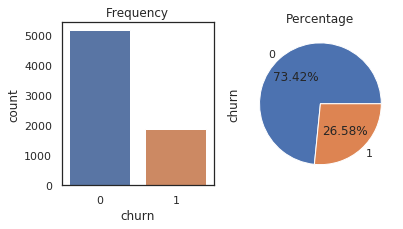

In [38]:
# Compare target values
fig, axs = plt.subplots(1,2,figsize=(6,3))
sns.countplot(target,ax=axs[0])
axs[0].set_title('Frequency')
target.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1], autopct='%1.2f%%')
axs[1].set_title('Percentage')

## Summary of Features

In [39]:
# Possible features to drop
drop_feat_analysis = pd.DataFrame(dict([ (k, pd.Series(v).sort_values()) for k, v in possible_drop_features.items() ], orient='index'))
pd.value_counts(drop_feat_analysis.values.flatten())

index                             10
phoneservice_yes                   3
multiplelines_no_phone_service     3
multiplelines_yes                  3
onlinebackup_yes                   2
totalcharges                       2
streamingtv_yes                    2
streamingmovies_yes                2
tenure                             2
deviceprotection_yes               2
paymentmethod_mailed_check         1
techsupport_yes                    1
monthlycharges                     1
gender_male                        1
dependents_yes                     1
internetservice_fiber_optic        1
internetservice_no                 1
dtype: int64

In [40]:
unique_drop_feat = pd.unique(drop_feat_analysis.dropna().drop(['orient'], axis=1).values.flatten())
print(len(unique_drop_feat))
print(unique_drop_feat)
print(features[unique_drop_feat].info())

13
['tenure' 'dependents_yes' 'gender_male' 'multiplelines_no_phone_service'
 'totalcharges' 'monthlycharges' 'deviceprotection_yes' 'phoneservice_yes'
 'onlinebackup_yes' 'techsupport_yes' 'multiplelines_yes'
 'streamingtv_yes' 'streamingmovies_yes']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 13 columns):
tenure                            7032 non-null float64
dependents_yes                    7032 non-null uint8
gender_male                       7032 non-null uint8
multiplelines_no_phone_service    7032 non-null uint8
totalcharges                      7032 non-null float64
monthlycharges                    7032 non-null float64
deviceprotection_yes              7032 non-null uint8
phoneservice_yes                  7032 non-null uint8
onlinebackup_yes                  7032 non-null uint8
techsupport_yes                   7032 non-null uint8
multiplelines_yes                 7032 non-null uint8
streamingtv_yes                   7032 no

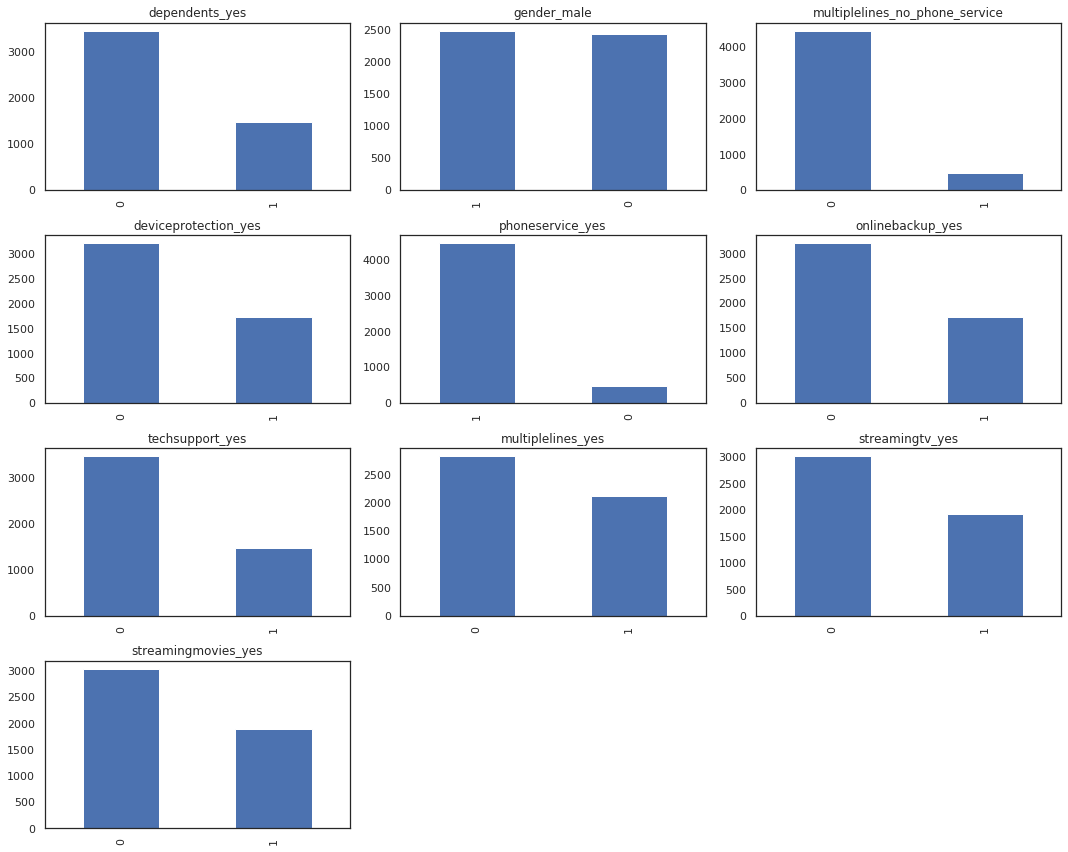

In [41]:
# Show distributions of features to possible drop
fig = plt.figure(figsize=(15, 12))
i = 0
for feat in unique_drop_feat:        
    if len(X_train[feat].unique()) < 5:
        i = i + 1
        plt.subplot(4, 3, i)
        f = plt.gca()
        f.set_title(feat)
        X_train[feat].value_counts().sort_values(ascending=False).plot.bar()
           
plt.tight_layout()

In [42]:
# Explore Features not marked for deletion
features.drop(unique_drop_feat, axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 11 columns):
seniorcitizen                          7032 non-null int64
partner_yes                            7032 non-null uint8
internetservice_fiber_optic            7032 non-null uint8
internetservice_no                     7032 non-null uint8
onlinesecurity_yes                     7032 non-null uint8
contract_one_year                      7032 non-null uint8
contract_two_year                      7032 non-null uint8
paperlessbilling_yes                   7032 non-null uint8
paymentmethod_credit_card_automatic    7032 non-null uint8
paymentmethod_electronic_check         7032 non-null uint8
paymentmethod_mailed_check             7032 non-null uint8
dtypes: int64(1), uint8(10)
memory usage: 498.5 KB


In [43]:
print(features.drop(unique_drop_feat, axis=1).columns.values)
print(type(X_train))

['seniorcitizen' 'partner_yes' 'internetservice_fiber_optic'
 'internetservice_no' 'onlinesecurity_yes' 'contract_one_year'
 'contract_two_year' 'paperlessbilling_yes'
 'paymentmethod_credit_card_automatic' 'paymentmethod_electronic_check'
 'paymentmethod_mailed_check']
<class 'pandas.core.frame.DataFrame'>


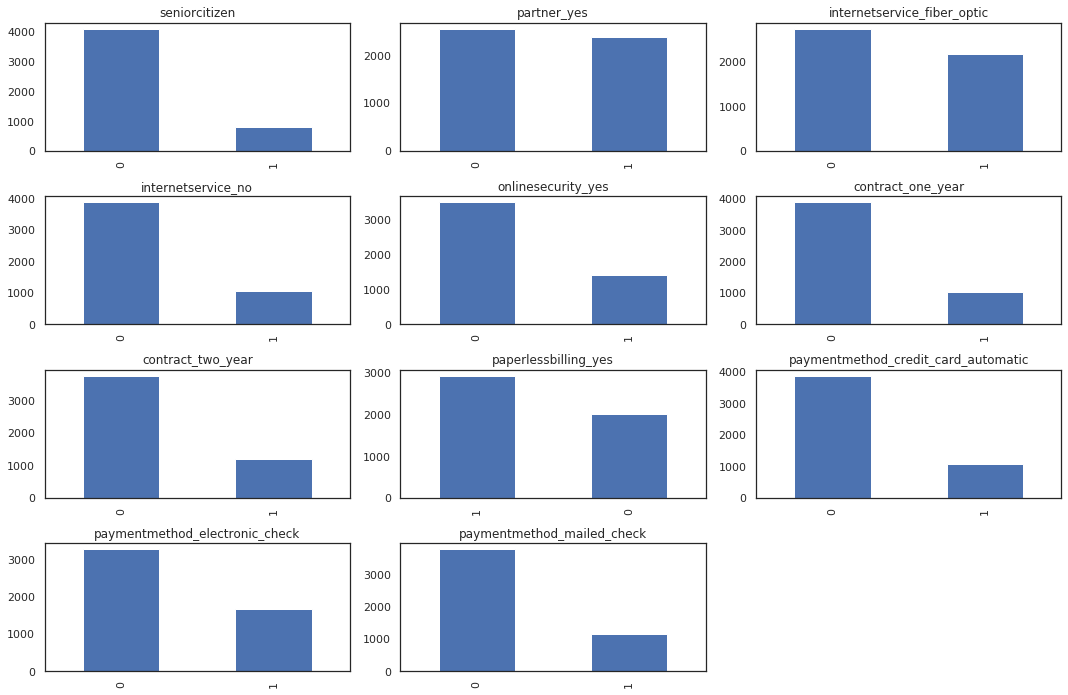

In [44]:
# Show distributions of features not marked for deletion
unique_keep_feat = features.drop(unique_drop_feat, axis=1).columns.values
fig = plt.figure(figsize=(15, 12))
i = 0
for feat in unique_keep_feat:        
    if len(X_train[feat].unique()) < 5:
        i = i + 1
        plt.subplot(5, 3, i)
        f = plt.gca()
        f.set_title(feat)
        X_train[feat].value_counts().sort_values(ascending=False).plot.bar()
           
plt.tight_layout()

In [45]:
X_train.isnull().sum()

seniorcitizen                          0
tenure                                 0
monthlycharges                         0
totalcharges                           0
gender_male                            0
partner_yes                            0
dependents_yes                         0
phoneservice_yes                       0
multiplelines_no_phone_service         0
multiplelines_yes                      0
internetservice_fiber_optic            0
internetservice_no                     0
onlinesecurity_yes                     0
onlinebackup_yes                       0
deviceprotection_yes                   0
techsupport_yes                        0
streamingtv_yes                        0
streamingmovies_yes                    0
contract_one_year                      0
contract_two_year                      0
paperlessbilling_yes                   0
paymentmethod_credit_card_automatic    0
paymentmethod_electronic_check         0
paymentmethod_mailed_check             0
dtype: int64

## Models

### Balance the Target

In [46]:
from imblearn.over_sampling import SMOTE

X_train_smote, y_train_smote = SMOTE().fit_sample(X_train,y_train)
X_train_smote_df = pd.DataFrame(X_train_smote, columns=X_train.columns)
y_train_smote_df = pd.DataFrame(y_train_smote)

X_test_smote, y_test_smote = SMOTE().fit_sample(X_test,y_test)
X_test_smote_df = pd.DataFrame(X_test_smote, columns=X_test.columns)
y_test_smote_df = pd.DataFrame(y_test_smote)

print('Before SMOTE:\n', y_train.value_counts())
print('After SMOTE:\n', y_train_smote_df['churn'].value_counts())

Using TensorFlow backend.


Before SMOTE:
 0    3608
1    1314
Name: churn, dtype: int64
After SMOTE:
 1    3608
0    3608
Name: churn, dtype: int64


### Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

model = LogisticRegression(solver='liblinear')
model.fit(X_train_smote, y_train_smote)

predictions = model.predict(X_test_smote)
score = model.score(X_test_smote, y_test_smote)

print('Accuracy = ', str(score))
print(confusion_matrix(y_test_smote, predictions))
print(classification_report(y_test_smote, predictions))

Accuracy =  0.8122186495176849
[[1184  371]
 [ 213 1342]]
              precision    recall  f1-score   support

           0       0.85      0.76      0.80      1555
           1       0.78      0.86      0.82      1555

    accuracy                           0.81      3110
   macro avg       0.82      0.81      0.81      3110
weighted avg       0.82      0.81      0.81      3110



### Feature Importance using Logistic Regression

In [48]:
# Let's see what features mattered most i.e. Feature Importance
# We sort on the co-efficients with the largest weights as those impact the resulting output the most 
coef = model.coef_[0]
coef = [abs(number) for number in coef]
print(coef)

[0.18023445839502472, 1.8080662141236754, 5.356288181386385, 1.2766485892621149, 0.1274086760867608, 0.1302203243893921, 0.2967630360159817, 0.8151123046648159, 3.4436040980879157, 0.727502406472141, 3.8353151373930077, 3.6349882832796516, 1.5939171912790546, 1.2367430209049384, 1.195336429141869, 1.5346329821840048, 1.5981862696386544, 1.5209746309575825, 1.0435770341992987, 1.8513270620195978, 0.1349793656563408, 0.5682603008868392, 0.10510567307852411, 0.6955103134004652]


In [49]:
# Sorting on Feature Importance
sorted_index = sorted(range(len(coef)), key = lambda k: coef[k], reverse = True)
for idx in sorted_index:
    print(X_train.columns[idx])

monthlycharges
internetservice_fiber_optic
internetservice_no
multiplelines_no_phone_service
contract_two_year
tenure
streamingtv_yes
onlinesecurity_yes
techsupport_yes
streamingmovies_yes
totalcharges
onlinebackup_yes
deviceprotection_yes
contract_one_year
phoneservice_yes
multiplelines_yes
paymentmethod_mailed_check
paymentmethod_credit_card_automatic
dependents_yes
seniorcitizen
paperlessbilling_yes
partner_yes
gender_male
paymentmethod_electronic_check


### Random Forests`

In [50]:
# Let's try Random Forests now to see if our resutls get better
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()
model_rf.fit(X_train_smote, y_train_smote)

predictions = model_rf.predict(X_test_smote)
score = model_rf.score(X_test_smote, y_test_smote)

print('Accuracy = ' + str(score))
print(confusion_matrix(y_test_smote, predictions))
print(classification_report(y_test_smote, predictions))

Accuracy = 0.7556270096463023
[[1260  295]
 [ 465 1090]]
              precision    recall  f1-score   support

           0       0.73      0.81      0.77      1555
           1       0.79      0.70      0.74      1555

    accuracy                           0.76      3110
   macro avg       0.76      0.76      0.75      3110
weighted avg       0.76      0.76      0.75      3110



In [51]:
importance = pd.concat(
    [pd.Series(rf_features),
     pd.Series(rf.feature_importances_)], axis=1)

importance.columns = ['feature', 'importance']
print(importance.sort_values(by='importance', ascending=False))

                          feature  importance
1                          tenure    0.617383
2                    totalcharges    0.363873
3  multiplelines_no_phone_service    0.010880
0                phoneservice_yes    0.007863


### Neural Net

In [52]:
# Uncomment next line for Collab
# %tensorflow_version 2.x 

In [53]:
# Check version and GPU
import tensorflow as tf
print(tf.__version__)
# tf.test.gpu_device_name()

2.0.0


In [54]:
# Create a simple model
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

inputs = X_train_smote.shape[1]
layers = inputs * 2
model = Sequential()
model.add(Dense(layers, kernel_initializer = 'uniform', activation = 'relu', input_dim=inputs))
model.add(Dense(inputs, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
opt = tf.keras.optimizers.Adam(0.01)
model.compile(optimizer=opt, 
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [55]:
# Display Model Summary and Show Parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 48)                1200      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Start Training Our Classifier 

# batch_size = 64
# epochs = 25
epochs = 100
history = model.fit(X_train_smote,
                    y_train_smote,
#                     batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (X_test_smote, y_test_smote))

score = model.evaluate(X_test_smote, y_test_smote, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7216 samples, validate on 3110 samples
Epoch 1/100
7216/7216 [==============================] - 1s 156us/sample - loss: 0.4708 - accuracy: 0.7740 - val_loss: 0.4400 - val_accuracy: 0.8071
Epoch 2/100
7216/7216 [==============================] - 0s 56us/sample - loss: 0.4490 - accuracy: 0.7884 - val_loss: 0.4390 - val_accuracy: 0.8003
Epoch 3/100
7216/7216 [==============================] - 0s 53us/sample - loss: 0.4372 - accuracy: 0.7930 - val_loss: 0.4348 - val_accuracy: 0.8026
Epoch 4/100
7216/7216 [==============================] - 0s 55us/sample - loss: 0.4336 - accuracy: 0.7953 - val_loss: 0.4412 - val_accuracy: 0.8058
Epoch 5/100
7216/7216 [==============================] - 0s 54us/sample - loss: 0.4306 - accuracy: 0.7963 - val_loss: 0.4349 - val_accuracy: 0.7981
Epoch 6/100
7216/7216 [==============================] - 0s 55us/sample - loss: 0.4209 - accuracy: 0.8039 - val_loss: 0.4454 - val_accuracy: 0.7875
Epoch 7/100
7216/7216 [==============================] - 0s 54u

In [57]:
predictions = model.predict(X_test_smote)
predictions = (predictions > 0.5)

print(confusion_matrix(y_test_smote, predictions))
print(classification_report(y_test_smote, predictions))

[[1208  347]
 [ 400 1155]]
              precision    recall  f1-score   support

           0       0.75      0.78      0.76      1555
           1       0.77      0.74      0.76      1555

    accuracy                           0.76      3110
   macro avg       0.76      0.76      0.76      3110
weighted avg       0.76      0.76      0.76      3110



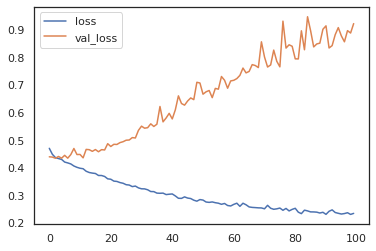

In [58]:
# Plot history
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Go Deeper with Checkpoints and Early Stopping

In [59]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

model2 = Sequential()
model2.add(Dense(2000, activation='relu', input_dim=inputs, kernel_regularizer=l2(0.01)))
model2.add(Dropout(0.3, noise_shape=None, seed=None))
model2.add(Dense(1000, activation='relu', input_dim=18, kernel_regularizer=l2(0.01)))
model2.add(Dropout(0.3, noise_shape=None, seed=None))
model2.add(Dense(500, activation = 'relu', kernel_regularizer=l2(0.01)))
model2.add(Dropout(0.3, noise_shape=None, seed=None))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

# Create checkpoint
checkpoint = ModelCheckpoint('deep_model_checkpoint.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only = True,
                             verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2000)              50000     
_________________________________________________________________
dropout (Dropout)            (None, 2000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               500500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [60]:
opt = tf.keras.optimizers.Adam(0.01)
model2.compile(optimizer=opt,
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [61]:
# Define earling stoppping criteria
from tensorflow.keras.callbacks import EarlyStopping 

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,  
                          verbose = 1,
                          restore_best_weights = True)

# Define callback list
callbacks = [earlystop, checkpoint]

In [ ]:
batch_size = 64
epochs = 25

history = model2.fit(X_train_smote,
                    y_train_smote,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    callbacks = callbacks,
                    validation_data = (X_test_smote, y_test_smote))

score = model2.evaluate(X_test_smote, y_test_smote, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 7216 samples, validate on 3110 samples
Epoch 1/25
2112/7216 [=======>......................] - ETA: 3s - loss: 3.2204 - accuracy: 0.7386